In [1]:

import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from models.llama.pitomekv import convert
from accelerate import Accelerator
from const import  (
   LLAMA2_7B,
   LLAMA3_8B,
   # LLAMA3_1_8B,
   LLAMA3_2_3B,
   LLAMA3_2_1B
)
import os

/media/caduser/da936c0b-edd7-470e-ab92-9b972b220fe7/chau/miniconda3/envs/pkv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import random
from tqdm.auto import tqdm

model2prompt = {
    "narrativeqa": "You are given a story, which can be either a novel or a movie script, and a question. Answer the question asconcisely as you can, using a single phrase if possible. Do not provide any explanation.\n\nStory: {context}\n\nNow, answer the question based on the story asconcisely as you can, using a single phrase if possible. Do not provide any explanation.\n\nQuestion: {input}\n\nAnswer:",
    "qasper": "You are given a scientific article and a question. Answer the question as concisely as you can, using a single phrase or sentence if possible. If the question cannot be answered based on the information in the article, write \"unanswerable\". If the question is a yes/no question, answer \"yes\", \"no\", or \"unanswerable\". Do not provide any explanation.\n\nArticle: {context}\n\n Answer the question based on the above article as concisely as you can, using a single phrase or sentence if possible. If the question cannot be answered based on the information in the article, write \"unanswerable\". If the question is a yes/no question, answer \"yes\", \"no\", or \"unanswerable\". Do not provide any explanation.\n\nQuestion: {input}\n\nAnswer:",
    "multifieldqa_en": "Read the following text and answer briefly.\n\n{context}\n\nNow, answer the following question based on the above text, only give me the answer and do not output any other words.\n\nQuestion: {input}\nAnswer:",
    "multifieldqa_zh": "阅读以下文字并用中文简短回答：\n\n{context}\n\n现在请基于上面的文章回答下面的问题，只告诉我答案，不要输出任何其他字词。\n\n问题：{input}\n回答：",
    "hotpotqa": "Answer the question based on the given passages. Only give me the answer and do not output any other words.\n\nThe following are given passages.\n{context}\n\nAnswer the question based on the given passages. Only give me the answer and do not output any other words.\n\nQuestion: {input}\nAnswer:",
    "2wikimqa": "Answer the question based on the given passages. Only give me the answer and do not output any other words.\n\nThe following are given passages.\n{context}\n\nAnswer the question based on the given passages. Only give me the answer and do not output any other words.\n\nQuestion: {input}\nAnswer:",
    "musique": "Answer the question based on the given passages. Only give me the answer and do not output any other words.\n\nThe following are given passages.\n{context}\n\nAnswer the question based on the given passages. Only give me the answer and do not output any other words.\n\nQuestion: {input}\nAnswer:",
    "dureader": "请基于给定的文章回答下述问题。\n\n文章：{context}\n\n请基于上述文章回答下面的问题。\n\n问题：{input}\n回答：",
    "gov_report": "You are given a report by a government agency. Write a one-page summary of the report.\n\nReport:\n{context}\n\nNow, write a one-page summary of the report.\n\nSummary:",
    "qmsum": "You are given a meeting transcript and a query containing a question or instruction. Answer the query in one or more sentences.\n\nTranscript:\n{context}\n\nNow, answer the query based on the above meeting transcript in one or more sentences.\n\nQuery: {input}\nAnswer:",
    "multi_news": "You are given several news passages. Write a one-page summary of all news. \n\nNews:\n{context}\n\nNow, write a one-page summary of all the news.\n\nSummary:",
    "vcsum": "下面有一段会议记录，请你阅读后，写一段总结，总结会议的内容。\n会议记录：\n{context}\n\n会议总结：",
    "trec": "Please determine the type of the question below. Here are some examples of questions.\n\n{context}\n{input}",
    "triviaqa": "Answer the question based on the given passage. Only give me the answer and do not output any other words. The following are some examples.\n\n{context}\n\n{input}",
    "samsum": "Summarize the dialogue into a few short sentences. The following are some examples.\n\n{context}\n\n{input}",
    "lsht": "请判断给定新闻的类别，下面是一些例子。\n\n{context}\n{input}",
    "passage_count": "There are some paragraphs below sourced from Wikipedia. Some of them may be duplicates. Please carefully read these paragraphs and determine how many unique paragraphs there are after removing duplicates. In other words, how many non-repeating paragraphs are there in total?\n\n{context}\n\nPlease enter the final count of unique paragraphs after removing duplicates. The output format should only contain the number, such as 1, 2, 3, and so on.\n\nThe final answer is: ",
    "passage_retrieval_en": "Here are 30 paragraphs from Wikipedia, along with an abstract. Please determine which paragraph the abstract is from.\n\n{context}\n\nThe following is an abstract.\n\n{input}\n\nPlease enter the number of the paragraph that the abstract is from. The answer format must be like \"Paragraph 1\", \"Paragraph 2\", etc.\n\nThe answer is: ",
    "passage_retrieval_zh": "以下是若干段落文字，以及其中一个段落的摘要。请确定给定的摘要出自哪一段。\n\n{context}\n\n下面是一个摘要\n\n{input}\n\n请输入摘要所属段落的编号。答案格式必须是\"段落1\"，\"段落2\"等格式\n\n答案是：",
    "lcc": "Please complete the code given below. \n{context}Next line of code:\n",
    "repobench-p": "Please complete the code given below. \n{context}{input}Next line of code:\n"
}

model2maxlen = {
   "llama2": 3950,
   "llama-2": 3950,
   "llama3": 7950,
   "llama-3": 7950,
   "mistral": 31500
}

dataset2maxlen = {
    "narrativeqa": 128,
    "qasper": 128,
    "multifieldqa_en": 64,
    "multifieldqa_zh": 64,
    "hotpotqa": 32,
    "2wikimqa": 32,
    "musique": 32,
    "dureader": 128,
    "gov_report": 512,
    "qmsum": 512,
    "multi_news": 512,
    "vcsum": 512,
    "trec": 64,
    "triviaqa": 32,
    "samsum": 128,
    "lsht": 64,
    "passage_count": 32,
    "passage_retrieval_en": 32,
    "passage_retrieval_zh": 32,
    "lcc": 64,
    "repobench-p": 64
}

sample_method = "topk"
max_capacity_prompts=512
eval_batch_size = 1
max_num_examples=None

def build_chat(prompt):
        prompt = f"[INST] {prompt} [/INST]"
        return prompt

def read_data(data_file:str, dataset:str, model_path:str):
   print("Loading data...")
    
   test_data = []
   
   prompts = []
   inputs = []
   contexts = []
   answerss = []
   lengths = []
   datasets = []
   languages = []
   all_classess = []
   _ids = []
   
   input_max_len = 0
   
   for key in model2maxlen:
      if key in model_path:
         model_max_len = model2maxlen[key]
         

   output_max_len = dataset2maxlen[dataset]
   with open(data_file) as fp:
      for line in fp:
         example = json.loads(line)
         
         
         length = example["length"]
         if length > input_max_len: input_max_len = length
         
         template = model2prompt[dataset]
         prompt = template.format(**example)
         
         if "llama2" in model_path.lower():
               prompt = build_chat(prompt)
               
         example["prompt"] = prompt
               
         test_data.append(example)
      
   print(f"Max Length is {input_max_len}")
      
   if max_num_examples and len(test_data) > max_num_examples:
      if sample_method == "random":
         test_data = random.sample(test_data, max_num_examples)
      elif sample_method == "topk":
         test_data = test_data[:max_num_examples]
   
   batch = {} 
   for example in test_data:
      
      prompts.append(example["prompt"])
      inputs.append(example["input"])
      contexts.append(example["context"])
      answerss.append(example["answers"])
      lengths.append(example["length"])
      datasets.append(example["dataset"])
      languages.append(example["language"])
      all_classess.append(example["all_classes"])
      _ids.append(example["_id"])

   print("Finish loading model and tokenizer")
   


   return prompts




In [3]:
accelerator = Accelerator()
model_checkpoint_path = LLAMA2_7B 
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_path)
model = AutoModelForCausalLM.from_pretrained(model_checkpoint_path, torch_dtype=torch.float16)
accelerator.prepare(model)
convert(model)
model.config.output_attention = True

directory = "attention"


if not os.path.exists(directory):
   os.makedirs(directory)


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


using pitome


In [4]:
def cal_energy(metric:torch.Tensor, sigma:float=0.1):
   metric = F.normalize(metric, p=2, dim=-1) 
   sim = metric@metric.transpose(-1,-2)
   energy_score = (torch.exp(-(((1 - sim)/sigma)**2 * 0.5))).mean(-1) *  1/(sigma*torch.sqrt(torch.tensor(2*torch.pi)))
   return energy_score


In [5]:
def manual_infer_with_llama_with_attention(prompt, max_length=50):

   input_ids = tokenizer.encode(prompt, return_tensors='pt').to(accelerator.device)
   print(input_ids.shape)
   all_layers_attentions = [] 

   for _ in range(max_length):

      raw_outputs = model(input_ids, output_attentions=True, return_dict=True)
      output = raw_outputs.logits
      next_token_logits = output[:, -1, :]
      
      attentions = raw_outputs.attentions

      next_token = torch.argmax(next_token_logits, dim=-1)

      input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)

      if next_token in tokenizer.all_special_ids:
         break
      
   for i in range(len(attentions)):
      all_layers_attentions.append(attentions[i].detach().cpu())
   return tokenizer.decode(input_ids[0], skip_special_tokens=True), input_ids[0], all_layers_attentions, raw_outputs.past_key_values

In [6]:
from datasets import load_dataset

datasets = ["multi_news"]

for dataset in datasets:
   data = load_dataset('THUDM/LongBench', dataset, split='test')


In [7]:
data = data.filter(lambda x: x["length"] < 600)

In [8]:
example = data[1]
template = model2prompt[dataset]
prompt = template.format(**example)
prompt = build_chat(prompt)

In [9]:
print(len(prompt))

2224


In [10]:

results, input_ids, all_layers_attentions, past_key_values = manual_infer_with_llama_with_attention(prompt)

torch.Size([1, 593])


The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 23.70 GiB of which 11.88 MiB is free. Including non-PyTorch memory, this process has 23.67 GiB memory in use. Of the allocated memory 21.51 GiB is allocated by PyTorch, and 715.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import numpy as np 
for layer_idx, attentions in enumerate(all_layers_attentions):
   attention = attentions * 10000

   attention_average = torch.mean(attention, dim=1)

   attention_average = attention_average[0]

   attention = attention_average

   id2token = []
   for id in input_ids:
      id2token.append(tokenizer.decode(id.item()))

   id2token = id2token[0:]
   indices = list(range(len(id2token)))



   num_heads = 1
   sequence_length = 10

   # attention = attention.cpu().detach().numpy()a
   energy = cal_energy(past_key_values[layer_idx][0], sigma=0.1)
   energy_np = energy.mean(1).cpu().detach().numpy()

   fig = plt.figure(figsize=(9, 10))
   gs = gridspec.GridSpec(9, 10)

   ax1 = fig.add_subplot(gs[:-1, :])
   ax2 = fig.add_subplot(gs[-1, :], sharex=ax1)

   # ax1.imshow(attention, vmax=100)
   ax1.imshow(attention, vmax=100)
   ax2.imshow(energy_np.reshape(1, -1), cmap='inferno', aspect='auto')
   # plt.xticks(ticks=np.arange(len(id2token)), labels=[], rotation=90)
   # plt.yticks(ticks=np.arange(len(id2token)), labels=[], rotation=90)
   # ax.set_xticks(np.arang (len(id2token)), labels=[])
   # ax.set_yticks(np.arange(len(id2token)), labels=[])
   plt.setp(ax1.get_xticklabels(), visible=False)
   
   # ax1.imshow(energy_np, aspect='auto', cmap='viridis')

   plt.tight_layout()
   plt.savefig(f'attention/layer{layer_idx}.png', dpi=300, format='png')
   plt.show()
   # break

In [ ]:
energy_np.shape

In [ ]:
energy_np.reshape(1, -1).shape

In [1]:
import pandas as pd

# Example dataset
data = {
    'attribute1': [1, 2, 3, 4, 5],
    'attribute2': [10, 20, 30, 40, 50]
}
df = pd.DataFrame(data)

# Calculate correlation
correlation = df['attribute1'].corr(df['attribute2'])
print(f"Correlation between attribute1 and attribute2: {correlation}")


Correlation between attribute1 and attribute2: 1.0


In [2]:
data['attribute1']

[1, 2, 3, 4, 5]

In [3]:
df['attribute1']

0    1
1    2
2    3
3    4
4    5
Name: attribute1, dtype: int64

In [2]:
import torch

mask = torch.tril(torch.ones(10, 10))

In [5]:
mask.sum(0)

tensor([10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.])

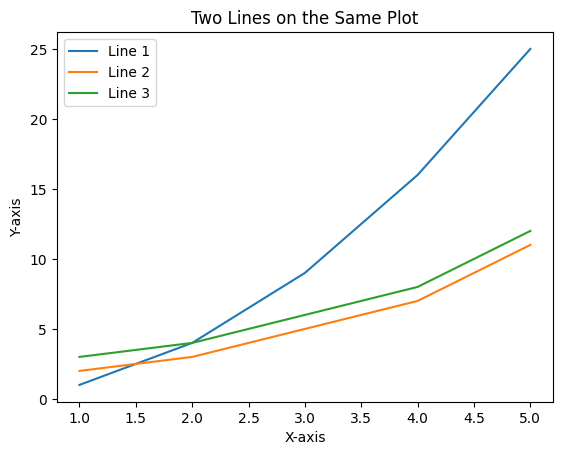

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([1, 4, 9, 16, 25])
y2 = np.array([2, 3, 5, 7, 11])
y3 = np.array([3, 4, 6, 8, 12])

# Plotting the lines
plt.plot(x, y1, label='Line 1')
plt.plot(x, y2, label='Line 2')
plt.plot(x, y3, label='Line 3')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Lines on the Same Plot')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [1]:
from transformers import LlamaForCausalLM
from const import LLAMA3_8B
from models.llama.pitomekv import convert 


model = LlamaForCausalLM.from_pretrained(LLAMA3_8B)

/media/caduser/da936c0b-edd7-470e-ab92-9b972b220fe7/chau/miniconda3/envs/pkv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


In [2]:
convert(model)

using pitome


In [3]:
model

LlamaForCausalLM(
  (model): PiToMeLlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x PiToMeLlamaDecoderLayer(
        (self_attn): PiToMeLlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

In [1]:
from datasets import load_dataset


dataset = load_dataset('THUDM/LongBench', 'multi_news_e', split='test')

Generating test split: 100%|██████████| 294/294 [00:00<00:00, 5621.47 examples/s]


In [ ]:
class LongBench(torch.utils.data.Dataset):
    def __init__(self, dataset, args):
        print('preparing data...')
        self.dataset = load_dataset('THUDM/LongBench', f'{dataset}_e', split='test')
        self.test_data = []
        self.prompts = []
        self.inputs = []
        self.contexts = []
        self.answers = []
        self.lengths = []
        self.datasets = []
        self.languages = []
        self.all_classess = []
        self._ids = []
        self.input_max_len = 0
        self.output_max_len = dataset2maxlen[dataset]

        self.dataset = dataset
        self.length = len(dataset)

        for sample in self.dataset:
            length = sample["length"]
            if length > input_max_len: input_max_len = length
            
            template = model2prompt[dataset]
            prompt = template.format(**sample)
            
            if "llama2" in args.model_path.lower():
                prompt = build_chat(prompt)
                
            sample["prompt"] = prompt
            self.test_data.append(sample)
        print(f"Max Length is {input_max_len}")
        if args.max_num_examples and len(test_data) > args.max_num_examples:
            if args.sample_method == "random":
                test_data = random.sample(test_data, args.max_num_examples)
            elif args.sample_method == "topk":
                test_data = test_data[:args.max_num_examples]

        for sample in test_data:
            self.prompts.append(sample["prompt"])
            self.inputs.append(sample["input"])
            self.contexts.append(sample["context"])
            self.answerss.append(sample["answers"])
            self.lengths.append(sample["length"])
            self.datasets.append(sample["dataset"])
            self.languages.append(sample["language"])
            self.all_classess.append(sample["all_classes"])
            self._ids.append(sample["_id"])


    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.dataset[idx]